# Simulating genotypes

I spoke with Brielin at ASHG. He acknowledged that hapgen2 doesn't work well. In particular, it produces really long haplotypes due to the way it recombines things. I will try to go back to generating genotypes using a MVN to binomial approach. There are a few difficulties to this approach:

1. Generating a variable from $N \left( 0, \Sigma \right)$ requires computing a decomposition of $\Sigma = \Sigma^\frac{1}{2} {\Sigma^\frac{1}{2}}^T $. Pretty much all the approaches to do this take $O \left( M^3 \right)$ time.
1. Due to numerical approximations, $\Sigma$ is often not positive definite. This prevents us from taking the root directly.
1. Depending upon how we massage $\Sigma$, we may end up with very large negative eigenvalues.

# Approach


## Idea 1

1. Find the top $K$ eigenvalues/eigenvectors, where top refers to positive eigenvalues with greatest magnitude. $ \Sigma \approx V_K \Lambda_K V_K^T $. These eigenvectors account for $ \sum_k \lambda_k / M $ of the variance.
1. Simulate $Z_K \sim N \left( 0, I_K \right)$ and $Z_M \sim N \left( 0, \frac{ M - \sum_k \lambda_k } { M } I_M \right) $
1. $ Z = V_K \lambda_K^\frac{1}{2} Z_K + Z_M $

### Drawbacks:

This is basically upweighting variance of SNPs with large loadings. I don't think this is producing $Z$ with variance approximately $S$. While the total variance remains the same, it isn't giving a realistic covariance structure. It's simply promoting the largest LD blocks, rather than making local covariance look good across the board.

In [11]:
import numpy as np
import numpy.random as nr
import numpy.linalg as nl

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def fromfile_tril(*args, **kwargs):
    """Read a symmetric matrix stored as just the lower triangular part.

    For an MxM matrix, the lower triangular part takes up just N=M*(M+1)$
    instead of M^2 bytes. Reversing this formula using the quadratic equ$
    M=(sqrt(1+8N)-1)/2. This is simply a wrapper around numpy.fromfile.
    """
    X = np.fromfile(*args, **kwargs)

    N = len(X)
    M = (np.sqrt(1+8*N)-1)/2
    if int(M) != M:
        raise ValueError('Length of matrix not of form M*(M+1)/2')
    M = int(M)

    Y = np.empty((M,M), X.dtype)
    indices = np.tril_indices(M)

    Y[indices] = Y[indices[::-1]] = X

    return(Y)

In [45]:
S = fromfile_tril('../common/ld/eas.22.ld.bin')

In [8]:
M = len(S)
K = 100

In [18]:
from scipy.sparse.linalg import eigsh

In [19]:
LK, VK = eigsh(S, K, which='LA')

In [20]:
SK = VK.dot(LK[:,None]*VK.T) + np.identity(M)*((M-LK.sum())/M)

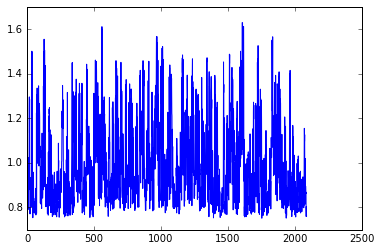

In [21]:
plt.plot(np.diag(SK))

The intuition appears correct. This doesn't really do the job.

## Idea 1b

Keep top 10 eigvals, set the rest to $\frac{M-\sum_k \lambda_k}{M-K}$.

In [6]:
L, V = nl.eigh(S)

In [23]:
L[:-K] = (M - L[-K:].sum()) / (M-K)

In [24]:
Sq = V.dot(L[:,None]*V.T)

In [26]:
np.trace(S), np.trace(SK), np.trace(Sq)

(2087.0, 2087.0, 2087.0)

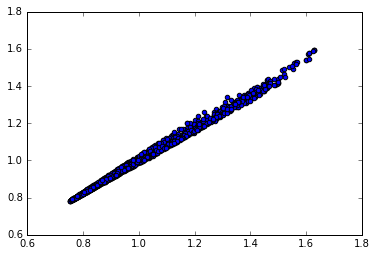

In [25]:
plt.scatter(np.diag(SK), np.diag(Sq))

## Idea 2: Banding the matrix

In [46]:
Sb = S.copy()
Sb[np.tril_indices_from(Sb, -100)] = 0

In [42]:
Lb, Vb = nl.eigh(Sb)

In [48]:
np.min(Sb - Sb.T), np.max(Sb - Sb.T)

(-0.53362217850279137, 0.53362217850279137)

In [63]:
np.argmax(np.triu(Sb-Sb.T)), np.argmax(np.triu(Sb.T-Sb))

(627268, 323785)

In [64]:
np.unravel_index(627268, Sb.shape)

(300, 1168)

In [65]:
np.unravel_index(323785, Sb.shape)

(155, 300)

In [67]:
Sb[155,300]

-0.23319126074118648